In [1]:
import os
%cd datasets
!bash get_datasets.sh
%cd ..

/Users/letunglam/Projects/deep-learning-training/minigrad/datasets
/Users/letunglam/Projects/deep-learning-training/minigrad


In [2]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
cifar10_dir = 'datasets/cifar-10-batches-py'

try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape: (10000,)


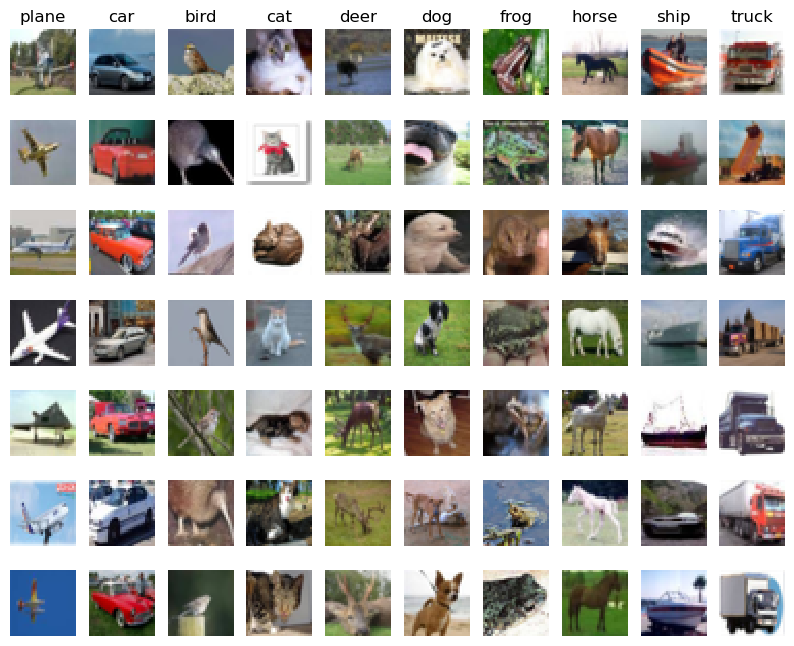

In [4]:
# Visualize some examples from the dataset.
# Show a few examples of trainign images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog','horse','ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will create a
# small development set as a subset of the training data; we can use this for
# development so out code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the orginal training set
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the orginal training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as out test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test data shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test data shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# AS a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


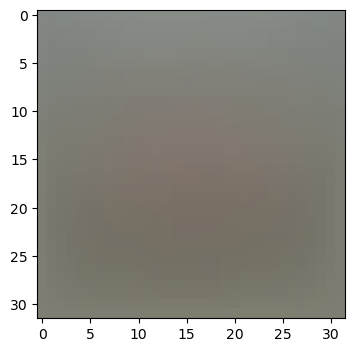

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# secound: subtract the mean image from the train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

#third: append the bias dimension of ones (i.e bias trick) so that our classifier
# only has to worry about optimizing a single weight matrx W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [8]:
# Evaluate the naive implementation of the loss
from classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.rand(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, out loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.316073
loss: 2.316073
sanity check: 2.302585


In [9]:
# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along serveral randomly chosen dimesions, and
# compute them with your analytically compted gradient. The numbers should math
# almost exactly along all dimesions.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(W, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient chekc once again with regularization turned on
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 1.965386 analytic: 1.965386, relative error: 1.700952e-08
numerical: 2.098072 analytic: 2.098072, relative error: 2.428842e-08
numerical: 1.424964 analytic: 1.424964, relative error: 3.084946e-08
numerical: 0.504289 analytic: 0.504288, relative error: 8.990671e-08
numerical: 1.943018 analytic: 1.943018, relative error: 3.504547e-08
numerical: -2.532369 analytic: -2.532369, relative error: 9.334867e-09
numerical: -0.810326 analytic: -0.810326, relative error: 1.261572e-07
numerical: -2.564033 analytic: -2.564033, relative error: 1.865606e-08
numerical: 2.811884 analytic: 2.811884, relative error: 1.243449e-08
numerical: -5.693406 analytic: -5.693406, relative error: 2.048499e-08
numerical: -1.722048 analytic: -1.722048, relative error: 3.025570e-09
numerical: -0.908607 analytic: -0.908607, relative error: 2.283774e-08
numerical: -1.688430 analytic: -1.688430, relative error: 1.538102e-08
numerical: -1.829323 analytic: -1.829323, relative error: 1.258703e-09
numerical: 0.62499

In [10]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.316073e+00 computed in 0.025203s
Vectorized loss: 2.316073e+00 computed in 0.002433s
difference: 0.000000


In [11]:
tic = time.time()
_ , grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
_ , grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other is a matrix, so
# use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.060019s
Vectorized loss and gradient: computed in 0.002301s
difference: 0.000000


In [12]:
from classifiers.linear_classifier import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took %s' % (toc - tic))

iteration 0 / 1500: loss 771.682824
iteration 100 / 1500: loss 282.945788
iteration 200 / 1500: loss 104.938795
iteration 300 / 1500: loss 39.751424
iteration 400 / 1500: loss 15.857456
iteration 500 / 1500: loss 7.162133
iteration 600 / 1500: loss 3.961308
iteration 700 / 1500: loss 2.727573
iteration 800 / 1500: loss 2.347180
iteration 900 / 1500: loss 2.210161
iteration 1000 / 1500: loss 2.156863
iteration 1100 / 1500: loss 2.123786
iteration 1200 / 1500: loss 2.124470
iteration 1300 / 1500: loss 2.114934
iteration 1400 / 1500: loss 2.103335
That took 6.428570985794067


In [ ]:
results = {}
best_val = -1
best_sofmax = None

num_folds = 20

for i in range(num_folds):
    lr = 10 ** np.random.uniform(-8, -5)
    reg = np.random.uniform(1e4, 5e4)
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr,reg=reg,
                  num_iters=200, verbose=False)
    
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(y_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_sofmax = softmax
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train val_accuracy: %%f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: -1.000000
